- 인공 지능: 사람이 할 수 있는 모든 활동을 기계가 하는 것.
- 기계 학습: 기계가 데이터로부터 학습하여 실행할 수 있도록 알고리즘 개발하는 분야.
- 딥러닝: 인공 신경망에 기반하여, 많은 양의 데이터를 학습해 높은 성능 이끌어 내는 분야.
---

머신러닝vs딥러닝: 스스로 학습 여부가 가장 큰 차이.
그렇다면 항상 딥러닝이 좋을까? no. 리소스가 많이 필요하게 되어 많은 시간, 비용 발생되기에.

---
CNN: 컨볼루션을 이용한 신경망 모델. numpy와 같은 행렬 데이터 처리에 특화된 모델.
 - CNN구조 1) 컨볼루션 레이어: 컨볼루션 연산을 수행(채널 증가, 크기 유지) 2) 풀링 레이어: 특징을 유지하며 크기를 축소하는 층 (채널 유지, 크기 축소) 3) 완전연결 레이어: 추출된 특징을 통해 분류를 수행하는 층
   - 컨볼루션? 커널 내 가장 큰 값 선택하여 출력하는 방식.
     - 1) 스트라이드: 한 번에 몇 칸씩 움직일지를 설정.
     - 2) 패딩: 최외곽 테두리 칸을 만들어 숫자 채움. 모서리에 있는 feature 추출 위한 방법.
   - 풀링? 이미지 크기를 줄이며, 강한 특징만 강조(=샘플링). 컨볼루션을 통해 추출된 특징 지도를 가지고, 크기를 줄이면서 특징을 강화하는 방법. 풀링에서는 패딩 적용x. 
 - 활성화 함수? 반복할수록 역전파로 얻는 오차의 기울기가 작아져 앞쪽 레이어의 가중치가 무시되는 경향(기울기 소실)이 있는 것. 과적합/과소적합 문제 발생. 활성화 함수는 이러한 기울기 소실 문제 최소화 위해 비선형 변환 수행.
 - 완전연결 레이어: 컨볼루션, 풀링 레이어를 통해 얻은 특징을 통해 데이터를 분류하는 레이어. Softmax함수를 통해 레이어의 출력을 라벨로 변환.
   - 소프트맥스 함수: CNN을 통한 네트워크 출럭값을 0~1 사이의 확률로 계산하는 함수.이미지는 각 라벨에 대한 일치 확률을 갖게 됨.

# MNIST 숫자 분류기

1. 필요 모듈 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

2. 모델 클래스 정의
    1) python의 nn.Module 클래스를 그대로 상속
    - 콘볼루션 사용법: nn.Conv2d(입력 채널, 출력 채널, 커널크기, 패딩)

In [2]:
# CNN 클래스 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        # 첫 번째 합성곱 레이어: 입력 채널 1, 출력 채널 32, 커널 크기 5x5, 패딩 2
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        # 두 번째 합성곱 레이어: 입력 채널 32, 출력 채널 64, 커널 크기 5x5, 패딩 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        # 세 번째 합성곱 레이어: 입력 채널 64, 출력 채널 128, 커널 크기 5x5, 패딩 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        # 완전 연결 레이어 1: 입력 크기 128*3*3, 출력 크기 128
        self.fc1 = nn.Linear(128*3*3, 128)
        # 완전 연결 레이어 2: 입력 크기 128, 출력 크기 10 (클래스 수)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 첫 번째 합성곱 레이어를 통과한 후 ReLU 활성화 함수를 적용하고 2x2 최대 풀링을 수행
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # 두 번째 합성곱 레이어를 통과한 후 ReLU 활성화 함수를 적용하고 2x2 최대 풀링을 수행
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # 세 번째 합성곱 레이어를 통과한 후 ReLU 활성화 함수를 적용하고 2x2 최대 풀링을 수행
        x = F.relu(F.max_pool2d(self.conv3(x), 2))    
        # 출력을 위해 텐서를 1차원으로 평탄화            
        x = x.view(-1, 128*3*3)
        # 첫 번째 완전 연결 레이어를 통과한 후 ReLU 활성화 함수를 적용
        x = F.relu(self.fc1(x))
        # 두 번째 완전 연결 레이어를 통과한 후 log-softmax 함수를 적용하여 클래스 확률을 계산
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

- 첫 번째 콘볼루션 레이어: 콘볼루션으로 32채널의 28x28 이미지가 만들어지고 Max-pooling을 통해 이미지 크기가 32x14x14로 압축.ReLU 함수를 이용해 비선형 변환


- 두 번째 콘볼루션 레이어: 콘볼루션으로 64채널의 14x14 이미지가 만들어지고 Max-pooling을 통해 이미지 크기가 7x7로 압축.ReLU 함수를 이용해 비선형 변환


- 세 번째 콘볼루션 레이어: 콘볼루션으로 128채널의 7x7 이미지가 만들어지고 Max-pooling을 통해 이미지 크기가 3x3로 압축.ReLU 함수를 이용해 비선형 변환


- 평탄화 및 완전 연결: 128층의 3x3 이미지 레이어가 평탄화를 통해 128x1x1의 1차원 데이터됨(fc1 레이어). 10x1x1 데이터로 선형변환함으로써 10개의 숫자 클래스에 속할 개별 확률을 가지는 데이터를 생산. (fc2 레이어). log_softmax 함수를 통해 정규화하여 라벨별 확률 계산.

3. MNIST 데이터셋 로드 및 전처리

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(), # 이미지를 텐서로 변환
    transforms.Normalize((0.1307,), (0.3081,)) # 정규화를 수행
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

- transforms.Compose: 여러 개의 이미지 전처리(transform)를 묶어서 사용할 수 있게 해주는 클래스
- transforms.ToTensor(): 이미지를 파이썬 이미지 라이브러리에서 지원하는 데이터 형식에서 PyTorch 텐서 형식으로 변환
- transforms.Normalize((0.1307,), (0.3081,)): 주어진 평균과 표준편차로 이미지를 정규화

- train=True: 학습 데이터셋을 로드
- download=True: 데이터셋이 로컬에 없을 경우 인터넷에서 데이터를 다운로드
- transform=transform: 앞서 정의한 전처리(transform)를 적용

- train=False: 테스트 데이터셋을 로드
- transform=transform: 동일한 전처리(transform)를 적용

- torch.utils.data.DataLoader: 데이터셋을 미니배치로 나누고 셔플링해주는 데이터 로더를 생성
- batch_size=64: 각 미니배치에 포함될 샘플의 개수를 지정
- shuffle=True: 데이터를 에포크마다 섞어줍니다. 이는 모델이 더 좋은 일반화를 할 수 있도록 돕습니다.

4. 모델, 손실 함수, 최적화 알고리즘 선언

In [6]:
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

- myCNN(): 앞서 정의한 myCNN 클래스의 인스턴스를 생성. 모델을 초기화하는 역할
- nn.CrossEntropyLoss(): 분류 작업에 적합한 손실 함수를 설정
- optim.SGD: SGD(Stochastic Gradient Descent) 옵티마이저를 설정. 모델의 파라미터를 업데이트하는 데 사용. model.parameters()를 통해 모델의 학습 가능한 파라미터를 전달하고, lr=0.01을 통해 학습률을 설정. momentum=0.5는 모멘텀을 나타내며, 이전 그래디언트 업데이트의 영향을 고려하여 새로운 업데이트를 계산하는 데 사용

5. 모델 학습

In [7]:
# 손실과 정확도를 저장하기 위한 리스트
train_losses = []
test_losses = []
test_accuracies = []

In [8]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0 # 현재 에포크의 훈련 손실을 저장하기 위한 변수를 초기화
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch{epoch}, Training loss: {train_loss:.4f}')

6. 모델 평가

In [11]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct +=pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)
        print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

7. 훈련 및 테스트 실행

In [12]:
for epoch in range(1, 20):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch1, Training loss: 0.0858
Test loss: 0.0566, Accuracy: 98.10%
Epoch2, Training loss: 0.0601
Test loss: 0.0483, Accuracy: 98.48%
Epoch3, Training loss: 0.0465
Test loss: 0.0333, Accuracy: 98.90%
Epoch4, Training loss: 0.0371
Test loss: 0.0326, Accuracy: 98.87%
Epoch5, Training loss: 0.0319
Test loss: 0.0352, Accuracy: 98.81%
Epoch6, Training loss: 0.0270
Test loss: 0.0310, Accuracy: 98.96%
Epoch7, Training loss: 0.0232
Test loss: 0.0278, Accuracy: 98.96%
Epoch8, Training loss: 0.0199
Test loss: 0.0243, Accuracy: 99.25%
Epoch9, Training loss: 0.0174
Test loss: 0.0238, Accuracy: 99.23%
Epoch10, Training loss: 0.0149
Test loss: 0.0288, Accuracy: 99.10%
Epoch11, Training loss: 0.0130
Test loss: 0.0273, Accuracy: 99.06%
Epoch12, Training loss: 0.0113
Test loss: 0.0249, Accuracy: 99.26%
Epoch13, Training loss: 0.0098
Test loss: 0.0270, Accuracy: 99.21%
Epoch14, Training loss: 0.0085
Test loss: 0.0233, Accuracy: 99.32%
Epoch15, Training loss: 0.0075
Test loss: 0.0252, Accuracy: 99.25%
Epoc

8. 결과 시각화(손실/정확도)

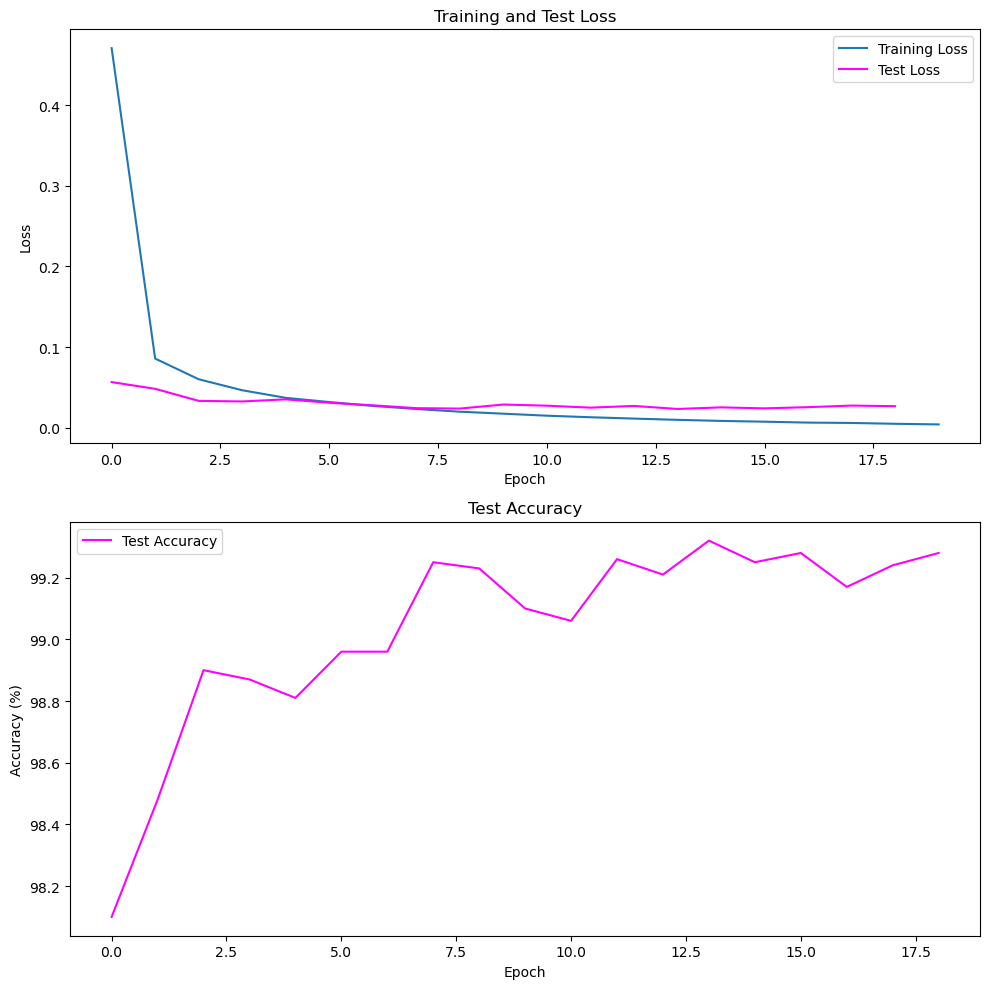

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss', color='magenta')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(test_accuracies, label='Test Accuracy', color='magenta')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

# 5/7 과제:MNIST가 아닌 다른 데이터셋으로, 예제와 같이 반복에 따른 학습/평가 loss와 정확도를 출력

---

### 본 데이터는 케글의 'Nespresso Coffee Pods Dataset'을 사용하였다. 네스프레소 캡슐을 분류하기 위한 이미지들이며 17개의 레이블과 총 1214개의 이미지로 이루어져 있다.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

1. 모델 클래스 정의

In [3]:
# CNN 클래스 정의
class nespressoCNN(nn.Module):
    def __init__(self):
        super(nespressoCNN, self).__init__()
        # 첫 번째 합성곱 레이어: 입력 채널 3, 출력 채널 32, 커널 크기 5x5, 패딩 2 
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        # 두 번째 합성곱 레이어: 입력 채널 32, 출력 채널 64, 커널 크기 5x5, 패딩 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        # 세 번째 합성곱 레이어: 입력 채널 64, 출력 채널 128, 커널 크기 5x5, 패딩 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        # 네 번째 합성곱 레이어
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        # 완전 연결 레이어 1: 입력 크기 256*14*14, 출력 크기 256
        self.fc1 = nn.Linear(256*14*14, 256) # 224/2/2/2/2 = 14 --> /2의 수는 합성곱 레이어 통과 횟수
        # 완전 연결 레이어 2: 입력 크기 256, 출력 크기 17 (클래스 수)
        self.fc2 = nn.Linear(256, 17)

    def forward(self, x):
        # 첫 번째 합성곱 레이어를 통과한 후 ReLU 활성화 함수를 적용하고 2x2 최대 풀링을 수행
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # 두 번째 합성곱 레이어를 통과한 후 ReLU 활성화 함수를 적용하고 2x2 최대 풀링을 수행
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # 세 번째 합성곱 레이어를 통과한 후 ReLU 활성화 함수를 적용하고 2x2 최대 풀링을 수행
        x = F.relu(F.max_pool2d(self.conv3(x), 2))    
        # 네 번째 합성곱 레이어를 통과한 후 ReLU 활성화 함수를 적용하고 2x2 최대 풀링을 수행
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        # 출력을 위해 텐서를 1차원으로 평탄화            
        x = x.view(-1, 256*14*14)
        # 첫 번째 완전 연결 레이어를 통과한 후 ReLU 활성화 함수를 적용
        x = F.relu(self.fc1(x))
        # 두 번째 완전 연결 레이어를 통과한 후 log-softmax 함수를 적용하여 클래스 확률을 계산
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

2. 데이터셋 로드 및 전처리

In [4]:
# 이미지 불러오기&전처리
import numpy as np
from torchvision import datasets, transforms

transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 데이터셋 불러오기
nespresso_dataset = datasets.ImageFolder(root="./Nespresso", transform=transform2)

# DataLoader를 사용하여 이미지 데이터를 배치 단위로 불러올 수 있음
nespresso_data_loader = torch.utils.data.DataLoader(nespresso_dataset, batch_size=1, shuffle=False)

# 이미지 데이터를 NumPy 배열로 변환하고 평균과 표준편차를 계산
pixel_values = []
for images, _ in nespresso_data_loader:
    pixel_values.append(images.numpy())

pixel_values = np.concatenate(pixel_values, axis=0)

# 픽셀 값의 평균과 표준편차 계산
mean = np.mean(pixel_values, axis=(0, 2, 3))
std = np.std(pixel_values, axis=(0, 2, 3))

print("평균:", mean)
print("표준편차:", std)

평균: [0.6224492 0.5839358 0.5443475]
표준편차: [0.29080006 0.2802946  0.30034882]


In [5]:
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6224492, 0.5839358, 0.5443475], 
                         std=[0.29080006, 0.2802946, 0.30034882])
])

# 데이터셋을 train과 test로 무작위로 분리
train_dataset, test_dataset = random_split(nespresso_dataset, [0.8, 0.2])

train_dataset.dataset.transform=transform2
test_dataset.dataset.transform=transform2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

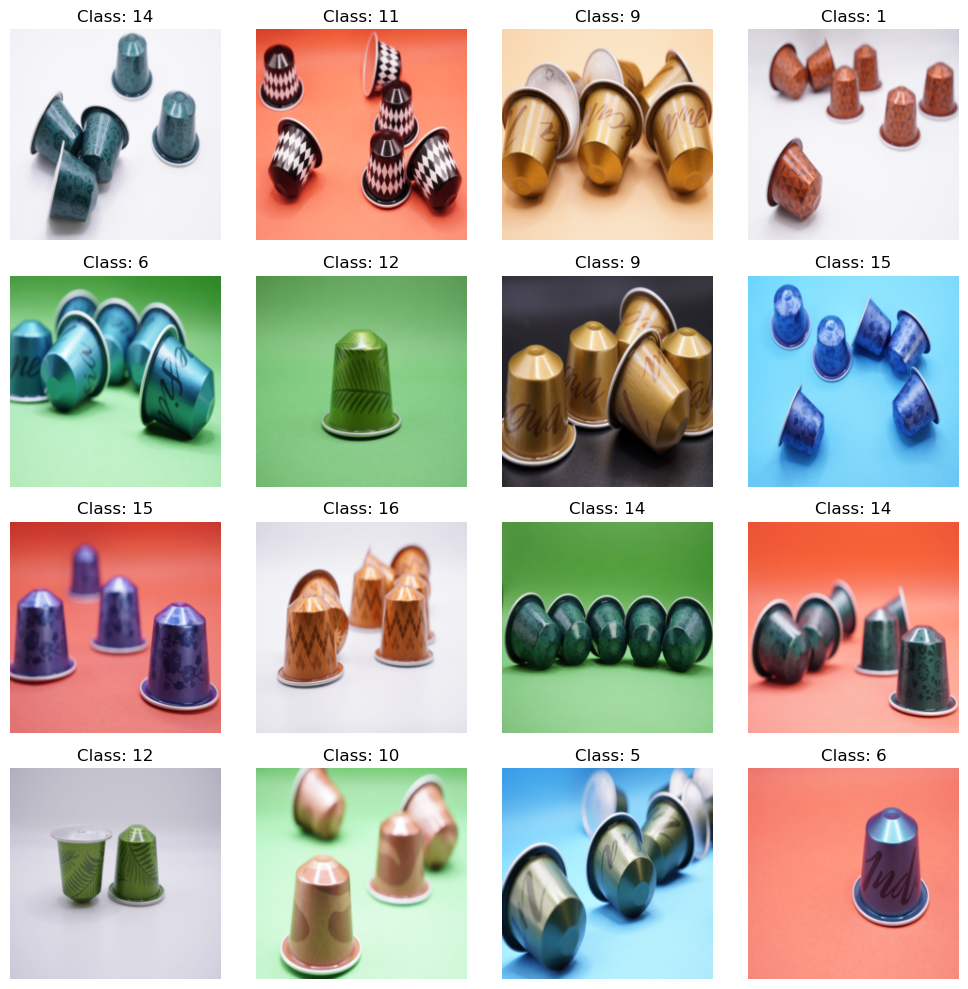

In [35]:
# train 데이터셋 이미지 일부 랜덤 시각화
import matplotlib.pyplot as plt

# train_loader에서 반복하여 이미지와 레이블을 가져와서 시각화
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()

for i, (images, labels) in enumerate(train_loader):
    for j in range(len(images)):
        index = i * len(images) + j  # 전체 인덱스 계산
        if index >= len(axes):  # 축 배열을 벗어나면 루프 종료
            break
        ax = axes[index]
        ax.imshow(images[j].permute(1, 2, 0))  # 이미지의 차원을 변경하여 imshow에 적합한 형식으로 변환
        ax.set_title(f"Class: {labels[j]}")
        ax.axis('off')

plt.tight_layout()
plt.show()


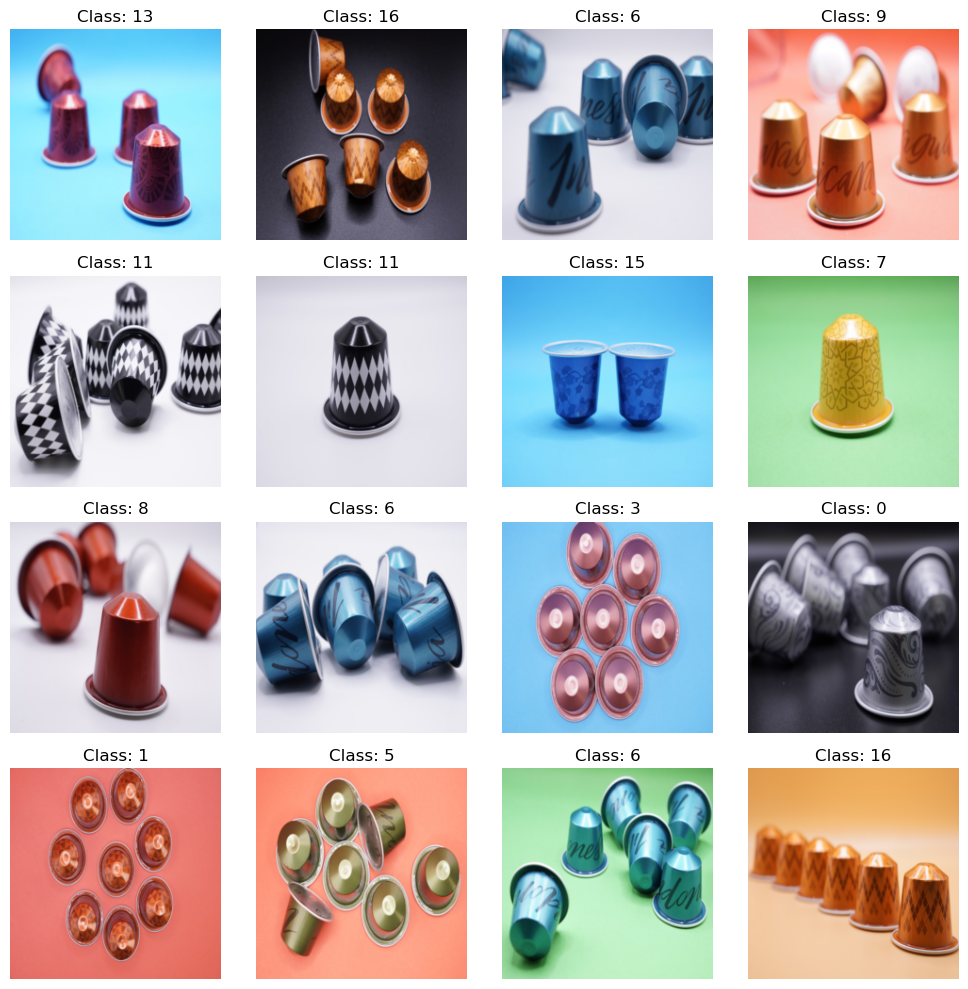

In [36]:
# test 데이터셋 이미지 일부 랜덤 시각화
import matplotlib.pyplot as plt

# train_loader에서 반복하여 이미지와 레이블을 가져와서 시각화
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()

for i, (images, labels) in enumerate(test_loader):
    for j in range(len(images)):
        index = i * len(images) + j  # 전체 인덱스 계산
        if index >= len(axes):  # 축 배열을 벗어나면 루프 종료
            break
        ax = axes[index]
        ax.imshow(images[j].permute(1, 2, 0))  # 이미지의 차원을 변경하여 imshow에 적합한 형식으로 변환
        ax.set_title(f"Class: {labels[j]}")
        ax.axis('off')

plt.tight_layout()
plt.show()


3. 모델, 손실 함수, 최적화 알고리즘 선언

In [34]:
model = nespressoCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

4. 모델 학습

In [35]:
# 손실과 정확도를 저장하기 위한 리스트
train_losses = []
test_losses = []
test_accuracies = []

In [36]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0 # 현재 에포크의 훈련 손실을 저장하기 위한 변수를 초기화
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch{epoch}, Training loss: {train_loss:.4f}')

5. 모델 평가

In [37]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct +=pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)
        print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

---
# 실행 결과
---
7. 결과 시각화
- 합성곱 레이어 3개, epoch 10, batch_size 변경 없이 실행 시 과적합 발생.

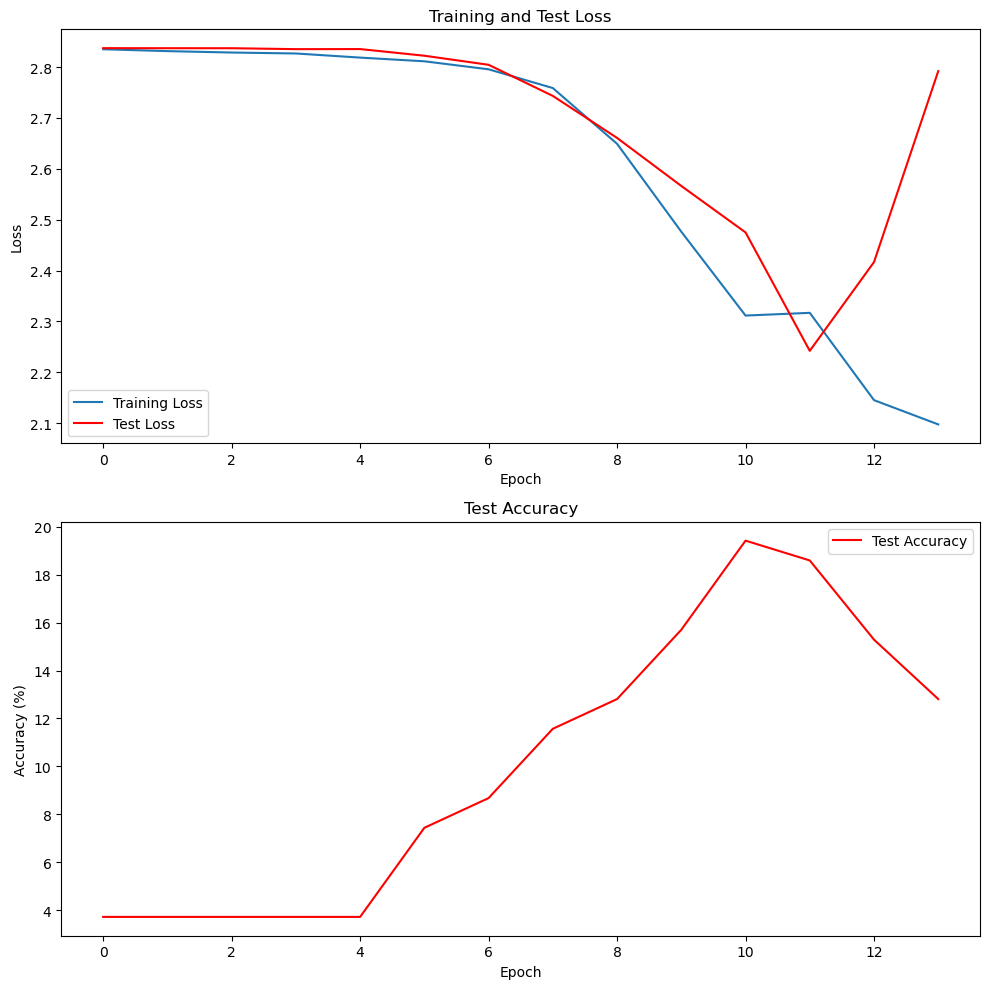

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss', color='Red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(test_accuracies, label='Test Accuracy', color='Red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

---
- 네 번째 합성곱 레이어 추가 및 모델을 Adam으로 변경 후 학습률(lr)을 0.001로, epoch를 50으로, batch_size를 train, test 모두 32로 설정하여 실행. 

6. 훈련 및 테스트 실행

In [16]:
# epoch=15실행. 실행 동안 test_loss가 5번 이상 개선되지 않을 때 조기 종료됨.
best_loss = float('inf')
no_improvement = 0
patience = 5

for epoch in range(1, 50):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    
    # 검증 손실 계산
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
        test_loss /= len(test_loader)
        
        # 최저 검증 손실 업데이트 및 조기 종료 체크
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement = 0
            # 모델 저장
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                break


Epoch1, Training loss: 2.8870
Test loss: 2.7830, Accuracy: 9.50%
Epoch2, Training loss: 2.6820
Test loss: 2.4255, Accuracy: 15.29%
Epoch3, Training loss: 2.3402
Test loss: 2.2286, Accuracy: 18.18%
Epoch4, Training loss: 2.1367
Test loss: 2.0213, Accuracy: 21.90%
Epoch5, Training loss: 1.9247
Test loss: 1.9818, Accuracy: 21.90%
Epoch6, Training loss: 1.8577
Test loss: 1.7474, Accuracy: 35.54%
Epoch7, Training loss: 1.5681
Test loss: 1.7775, Accuracy: 38.43%
Epoch8, Training loss: 1.4275
Test loss: 1.5177, Accuracy: 41.74%
Epoch9, Training loss: 1.2050
Test loss: 1.5790, Accuracy: 40.08%
Epoch10, Training loss: 1.0008
Test loss: 1.7684, Accuracy: 43.80%
Epoch11, Training loss: 0.8431
Test loss: 1.3817, Accuracy: 47.93%
Epoch12, Training loss: 0.7586
Test loss: 1.7781, Accuracy: 48.76%
Epoch13, Training loss: 0.7263
Test loss: 1.4936, Accuracy: 48.76%
Epoch14, Training loss: 0.4241
Test loss: 1.6634, Accuracy: 50.83%
Epoch15, Training loss: 0.3465
Test loss: 1.6072, Accuracy: 54.55%
Epoch

7. 결과 시각화
- accuracy는 높아졌으나 test, train의 loss를 보았을 때 과적합의 가능성 시사하는 것으로 보여짐. 추가적인 하이퍼파라미터의 조정이나 이미지 증강이 이루어진다면 개선된 결과를 얻을 수 있을 것으로 예상된다.

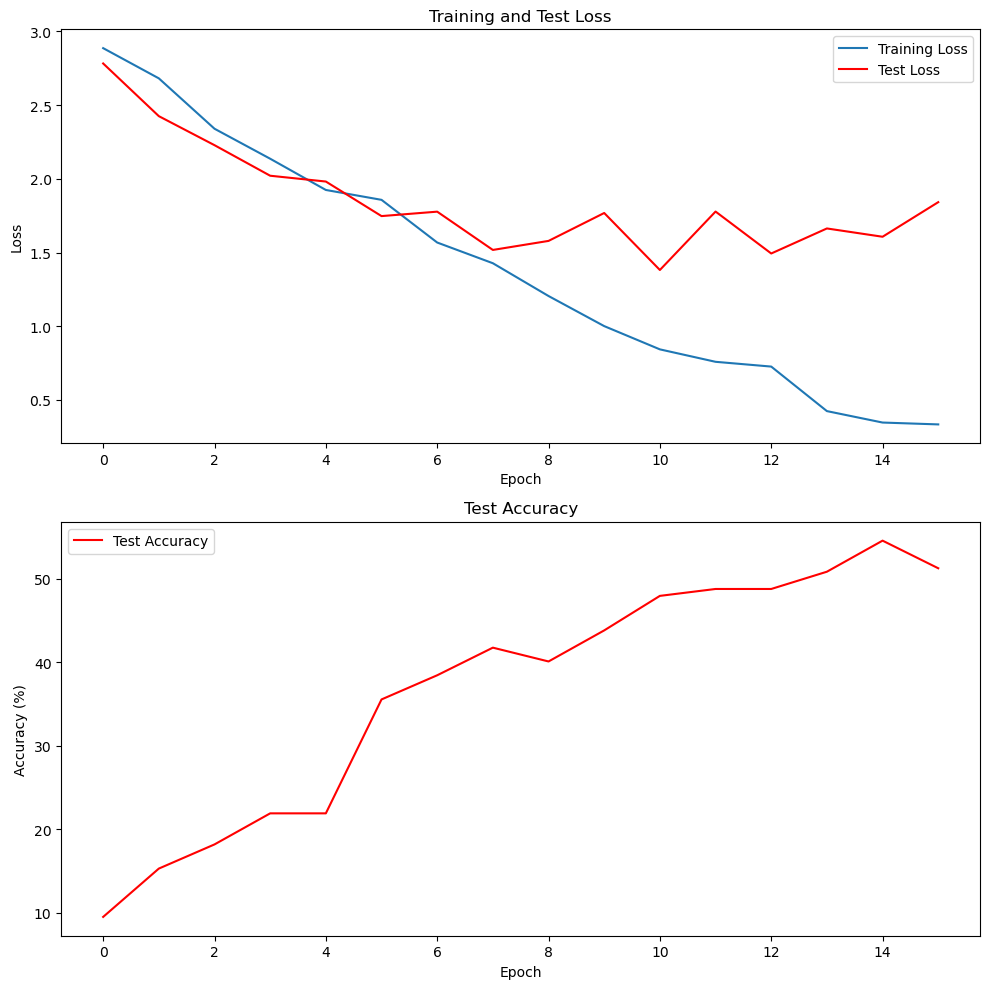

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss', color='Red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(test_accuracies, label='Test Accuracy', color='Red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

- 추가적으로 SGD 모델을 반복 시도해보았으나 모델의 개선점이 보이지 않아 Adam으로 최종 설정하는 것이 좋아보인다고 판단됨.